In [27]:
from pandas import DataFrame, read_csv
from numpy import argmax
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from keras import metrics
from os import listdir
from hyperparameter import EPOCHS, VERBOSE, BATCH_SIZE

In [4]:
df_train = read_csv('../churn_prediction_data/train.csv')
df_test = read_csv('../churn_prediction_data/test.csv')

In [5]:
lbl = LabelEncoder()

df_train['Geography'] = lbl.fit_transform(df_train['Geography'].astype(str))
df_train['Gender'] = lbl.fit_transform(df_train['Gender'].astype(str))

df_test['Geography'] = lbl.fit_transform(df_test['Geography'].astype(str))
df_test['Gender'] = lbl.fit_transform(df_test['Gender'].astype(str))

In [6]:
train_data = df_train.loc[:, 'CreditScore': 'EstimatedSalary']
train_label = df_train['Exited']

x_train, x_test, y_train, y_test = train_test_split(
    train_data, train_label, test_size=0.25, random_state=48)

In [7]:
scaler = StandardScaler()
x_train_standardized = scaler.fit_transform(x_train)
x_test_standardized = scaler.transform(x_test)

In [8]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [9]:
METRICS = [
    'accuracy',
    metrics.Precision(name='precision', thresholds=0.7),
    tfa.metrics.F1Score(num_classes=2)
]

In [10]:
number_of_features = x_train_standardized.shape[1]

network = Sequential()
network.add(Dense(units=9, activation='relu', input_dim=number_of_features))
network.add(Dense(units=18, activation='relu'))
network.add(Dense(units=18, activation='relu', kernel_regularizer=l2(0.01))) #kernel_regularizer=regularizers.l2(0.01)
network.add(Dense(units=9, activation='relu', kernel_regularizer=l2(0.01)))
network.add(Dense(units=9, activation='relu'))
network.add(Dense(units=2, activation='sigmoid'))

network.compile(
    loss='binary_crossentropy', 
    optimizer='rmsprop', 
    metrics=METRICS)

network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 99        
_________________________________________________________________
dense_1 (Dense)              (None, 18)                180       
_________________________________________________________________
dense_2 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 171       
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 20        
Total params: 902
Trainable params: 902
Non-trainable params: 0
__________________________________________________________

In [11]:
history = network.fit(
    x_train_standardized, 
    y_train, 
    epochs=EPOCHS, 
    verbose=VERBOSE, 
    batch_size=BATCH_SIZE, 
    validation_data=(x_test_standardized, y_test)
    )

Epoch 1/150


2021-12-03 03:50:50.394079: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


120/120 [==============================] - 2s 3ms/step - loss: 0.7665 - accuracy: 0.7905 - precision: 0.8020 - f1_score: 0.4415 - val_loss: 0.6206 - val_accuracy: 0.8070 - val_precision: 0.8303 - val_f1_score: 0.4466
Epoch 2/150
120/120 [==============================] - 0s 2ms/step - loss: 0.5757 - accuracy: 0.7923 - precision: 0.8414 - f1_score: 0.4421 - val_loss: 0.5066 - val_accuracy: 0.8070 - val_precision: 0.8740 - val_f1_score: 0.4466
Epoch 3/150
120/120 [==============================] - 0s 1ms/step - loss: 0.4987 - accuracy: 0.7923 - precision: 0.8665 - f1_score: 0.4421 - val_loss: 0.4642 - val_accuracy: 0.8070 - val_precision: 0.8990 - val_f1_score: 0.4466
Epoch 4/150
120/120 [==============================] - 0s 1ms/step - loss: 0.4676 - accuracy: 0.7923 - precision: 0.8736 - f1_score: 0.4421 - val_loss: 0.4409 - val_accuracy: 0.8070 - val_precision: 0.8962 - val_f1_score: 0.4466
Epoch 5/150
120/120 [==============================] - 0s 1ms/step - loss: 0.4526 - accuracy: 0.

In [12]:
network_result = network.evaluate(x_test_standardized, y_test, batch_size=10, verbose=1)
for name, value in zip(network.metrics_names, network_result):
    print(name, ':', value)

200/200 [==============================] - 1s 2ms/step - loss: 0.3383 - accuracy: 0.8665 - precision: 0.9044 - f1_score: 0.7581
loss : 0.338335782289505
accuracy : 0.8665000200271606
precision : 0.9044032692909241
f1_score : [0.92003596 0.5960666 ]


In [13]:
final = (network_result[1] + network_result[2] + sum(network_result[3])/2) / 3
final

0.8429848551750183

In [23]:
def plot_evaluate(model_history, value:str):
    training_value = model_history.history[value]
    test_value  = model_history.history[f'val_{value}']
    epoch_count = range(1, len(training_value)+1)
    plt.plot(epoch_count, training_value)
    plt.plot(epoch_count, test_value)
    plt.legend([f'training_{value}', f'test_{value}'])
    plt.xlabel('epoch')
    plt.ylabel(value)
    plt.show()

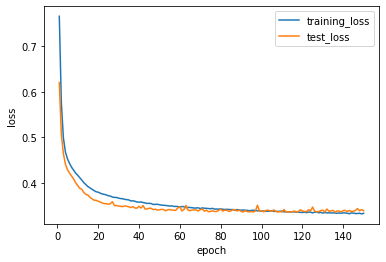

In [24]:
plot_evaluate(history, 'loss')

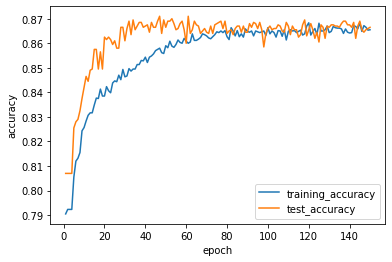

In [25]:
plot_evaluate(history, 'accuracy')

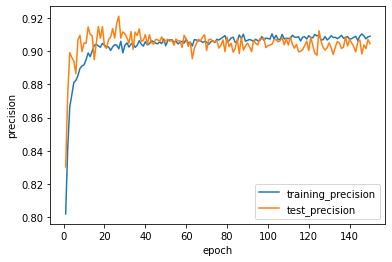

In [26]:
plot_evaluate(history, 'precision')

In [28]:
X_test = df_test.loc[:, 'CreditScore': 'EstimatedSalary']
X_test_standardized = scaler.transform(X_test)
Y_predictions_label = argmax(network.predict(X_test_standardized), axis=1)
df_upload = DataFrame({
    'RowNumber': list(df_test.RowNumber), 
    'Exited': Y_predictions_label
})
df_upload.to_csv('../churn_prediction_data/DNN.csv')
print(listdir())

['DNN_clean.ipynb', '__pycache__', 'hyperparameter.py', 'LogisticRegression.ipynb', 'XGBoost_CatBoost.ipynb', 'DNN.ipynb', 'SVM.ipynb']
['DNN_clean.ipynb', '__pycache__', 'hyperparameter.py', 'LogisticRegression.ipynb', 'XGBoost_CatBoost.ipynb', 'DNN.ipynb', 'SVM.ipynb']
